In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# import zipfile
# import os

# # Define the path to your zip file and the extraction directory
# zip_file_path = '/content/drive/MyDrive/stitching_ds.zip'  # Update this with the path to your zip file
# extraction_dir = '/content/Stitching'   # Directory where you want to extract files

# # Create the extraction directory if it doesn't exist
# os.makedirs(extraction_dir, exist_ok=True)

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_dir)

# print(f'Files extracted to: {extraction_dir}')

Files extracted to: /content/Stitching


In [4]:
# import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

cuda


In [5]:
!pip install stitching -q
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.5 MB/s eta 0:00:00


In [30]:
import requests
from PIL import Image
from io import BytesIO
from diffusers import LDMSuperResolutionPipeline
import stitching
import torch
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [31]:
# # load model and scheduler
model_id = model_id = "CompVis/ldm-super-resolution-4x-openimages"
pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

# from realesrgan import RealESRGANPipeline
# from PIL import Image

# # Load the model
# model = RealESRGAN.from_pretrained('RealESRGAN_x4plus')

# model_id = "RealESRGAN"
# pipeline = RealESRGANPipeline.from_pretrained(model_id)
# pipeline = pipeline.to(device)


vqvae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


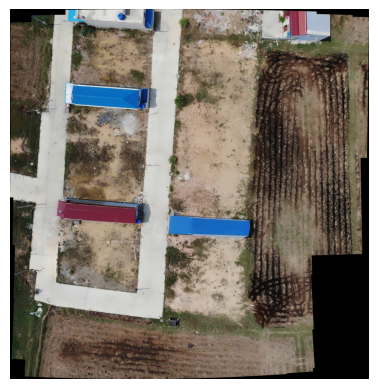

Final panorama saved to /content/final_panorama.png


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_dir = "/content/Stitching/drone"

def load_images(image_dir):
    images = []
    for file_name in sorted(os.listdir(image_dir))[:20]:  # image counts
        if file_name.endswith(".jpg") or file_name.endswith(".png") or file_name.endswith(".JPG"):
            image_path = os.path.join(image_dir, file_name)
            img = cv2.imread(image_path)
            if img is not None:
                img_resized = cv2.resize(img, (2720, 1530), interpolation=cv2.INTER_AREA) # change the input image size
                images.append(img_resized)
            else:
                print(f"Failed to load image: {file_name}")
    return images

def stitch_images(images, confidence_threshold=0.6):
    stitcher = cv2.Stitcher_create(cv2.Stitcher_PANORAMA)
    stitcher.setPanoConfidenceThresh(confidence_threshold)
    status, panorama = stitcher.stitch(images)
    return status, panorama

images = load_images(image_dir)

status, final_panorama = stitch_images(images, confidence_threshold=0.95) # change the threshold accordingly

if final_panorama is not None and status == cv2.Stitcher_OK:
    output_file = "/content/final_panorama.png"
    cv2.imwrite(output_file, final_panorama)
    plt.imshow(cv2.cvtColor(final_panorama, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    print(f"Final panorama saved to {output_file}")
else:
    if status == cv2.Stitcher_ERR_NEED_MORE_IMGS:
        print("Error: Need more images to stitch.")
    elif status == cv2.Stitcher_ERR_HOMOGRAPHY_EST_FAIL:
        print("Error: Homography estimation failed.")
    elif status == cv2.Stitcher_ERR_CAMERA_PARAMS_ADJUST_FAIL:
        print("Error: Camera parameter adjustment failed.")
    else:
        print("Stitching failed with status code:", status)
